In [556]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import xgboost as xgb
from prophet import Prophet
import tensorflow as tf
from tensorflow import keras
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from scipy.optimize import linprog


import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

## Connect to NREL API to fetch solar radiation data for New York // REQUESTS

In [454]:
# NREL API Key to pull solar and wind data
# Change the API key
# You need to register to NREL API to receive your key 

API_Key= "09T2SRKaihnjvrq6YSzzlbPuEAPg341WbBRUjX7r"

# Define NY's latitude & longitude
Latitude, Longitude = 40.7128, -74.0060  

# NREL Solar Radiation API URL
solar_url = f"https://developer.nrel.gov/api/solar/solar_resource/v1.json?api_key={API_Key}&lat={Latitude}&lon={Longitude}"

# Make the API request
response = requests.get(solar_url)
solar_data = response.json()

print(solar_data)




{'version': '1.0.0', 'warnings': [], 'errors': [], 'metadata': {'sources': ['Perez-SUNY/NREL, 2012']}, 'inputs': {'lat': '40.7128', 'lon': '-74.006'}, 'outputs': {'avg_dni': {'annual': 3.79, 'monthly': {'jan': 3.23, 'feb': 3.89, 'mar': 4.09, 'apr': 4.1, 'may': 4.16, 'jun': 4.23, 'jul': 4.32, 'aug': 4.18, 'sep': 4.1, 'oct': 3.42, 'nov': 2.79, 'dec': 2.97}}, 'avg_ghi': {'annual': 3.93, 'monthly': {'jan': 2.0, 'feb': 2.89, 'mar': 3.91, 'apr': 4.77, 'may': 5.51, 'jun': 5.85, 'jul': 5.85, 'aug': 5.17, 'sep': 4.3, 'oct': 3.03, 'nov': 2.08, 'dec': 1.75}}, 'avg_lat_tilt': {'annual': 4.62, 'monthly': {'jan': 3.61, 'feb': 4.45, 'mar': 4.92, 'apr': 5.05, 'may': 5.24, 'jun': 5.31, 'jul': 5.46, 'aug': 5.28, 'sep': 5.1, 'oct': 4.26, 'nov': 3.44, 'dec': 3.34}}}}


## Plot the solar radiation with data provided by NREL API // MATPLOTLIB

,Month,Irradiance
0,2024-01-01,3.23
1,2024-02-01,3.89
2,2024-03-01,4.09
3,2024-04-01,4.10
4,2024-05-01,4.16
5,2024-06-01,4.23
6,2024-07-01,4.32
7,2024-08-01,4.18
8,2024-09-01,4.10
9,2024-10-01,3.42


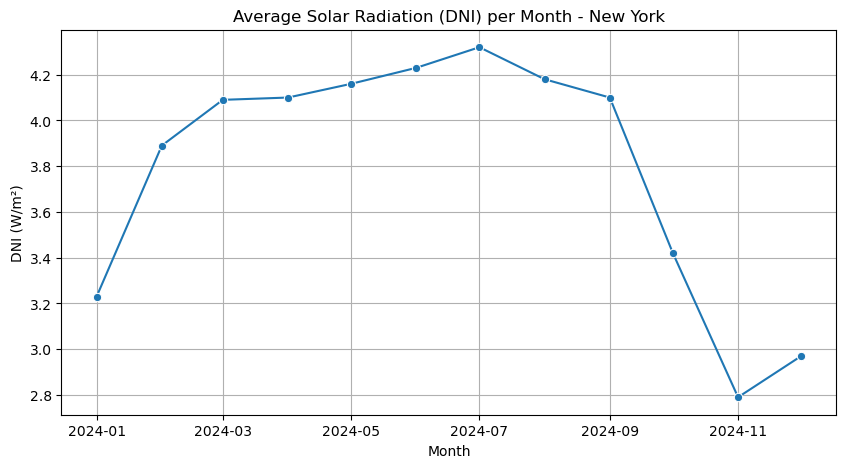

In [457]:
# Get Solar DNI data
dni_data = solar_data["outputs"]["avg_dni"]["monthly"]

# Convert to DataFrame
solar_df = pd.DataFrame(list(dni_data.items()), columns=["Month", "Irradiance"])

# Convert month names to proper order
month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
solar_df["Month"] = pd.Categorical(solar_df["Month"], categories=month_order, ordered=True)
solar_df = solar_df.sort_values("Month")
# Convert 'Month' to datetime format with year 2024
solar_df["Month"] = pd.to_datetime(solar_df["Month"].astype(str) + " 2024", format="%b %Y")

# Display the DataFrame
display(solar_df)
    
# Plot Solar Radiation Data
plt.figure(figsize=(10,5))
sns.lineplot(x=solar_df["Month"], y=solar_df["Irradiance"], marker="o")
plt.title("Average Solar Radiation (DNI) per Month - New York")
plt.xlabel("Month")
plt.ylabel("DNI (W/m²)")
plt.grid()
plt.show()

## Use ARIMA (Autoregressive moving average) to forecast solar radiation by using 2024 data. 


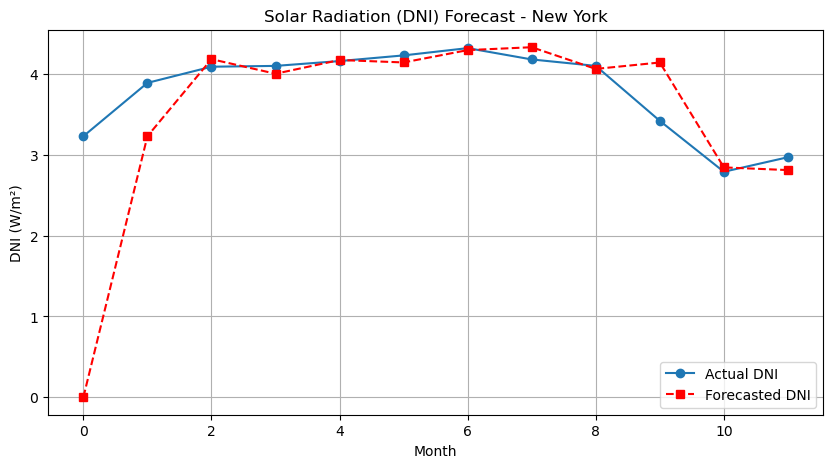

In [460]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model
model = ARIMA(solar_df["Irradiance"], order=(1,1,1))  # (p,d,q) values can be tuned
model_fit = model.fit()

# Make predictions
solar_df["Forecasted Irradiance"] = model_fit.predict(start=0, end=len(solar_df)-1)

# Plot actual vs forecasted data
plt.figure(figsize=(10,5))
plt.plot(solar_df.index, solar_df["Irradiance"], marker="o", label="Actual DNI")
plt.plot(solar_df.index, solar_df["Forecasted Irradiance"], marker="s", linestyle="dashed", label="Forecasted DNI", color="red")
plt.title("Solar Radiation (DNI) Forecast - New York")
plt.xlabel("Month")
plt.ylabel("DNI (W/m²)")
plt.legend()
plt.grid()
plt.show()


### !Note that ARIMA starts from value 0, this can be fixed via forecasting the first value fro previous years.

## Function to define solar panel characteristics.
## The example input below is the average solar panel characteristics. 

In [515]:
def define_solar_panel(efficiency: float, temp_coefficient: float, degradation_rate: float, install_cost_per_watt: float, maintenance_cost_per_kw: float, lifespan: float,  inverter_efficiency: float,  loss_factor: float):
     
    
    #Defines solar panel characteristics with default or user-provided values.
    #Returns a dictionary containing all key specifications.
    
    return {
        "Efficiency": efficiency, # 20% efficiency
        "Temperature Coefficient": temp_coefficient, # -0.4% per °C
        "Degradation Rate": degradation_rate, # 0.5% per year
        "Installation Cost per Watt": install_cost_per_watt, # $3 per Watt
        "Maintenance Cost per kW": maintenance_cost_per_kw, # $20 per kW per year
        "Lifespan": lifespan, # 25 years
        "Inverter Efficiency": inverter_efficiency, # 95%
        "Loss Factor": loss_factor, # 10% losses due to dirt/shading
    }

# Example usage for the Dictionary with standard solar panel values:
solar_panel_specs = define_solar_panel(0.2,-0.4,0.5,3.0,20.0,25.0,0.95,0.1)
print(solar_panel_specs)


{'Efficiency': 0.2, 'Temperature Coefficient': -0.4, 'Degradation Rate': 0.5, 'Installation Cost per Watt': 3.0, 'Maintenance Cost per kW': 20.0, 'Lifespan': 25.0, 'Inverter Efficiency': 0.95, 'Loss Factor': 0.1}


## Calculate solar generation for both actual and forecasted solar irradiation data
### The function utilizes Solar Panel Dictionary to fetch efficiency and performance ratio : (inverter efficiency-lossfactor) 
### It utilizes NREL solar irradiation data and we pass a solar panel area

In [518]:

def calculate_solar_energy(nrel_irradiance: pd.DataFrame, panel_area: float, efficiency: float, performance_ratio: float = 0.8):
    """
    Calculate the monthly solar energy generation based on NREL irradiance data.
    
    Parameters:
        nrel_irradiance (pd.DataFrame): Monthly solar irradiance data (kWh/m²). Both actual and forecasted data is already in the DF
        panel_area (float): Total solar panel area (m²). User need to pass input to calculate
        efficiency (float): Solar panel efficiency (0-1). Efficiency is already defined in solar specs function
        performance_ratio (float, optional): System performance ratio (default = 0.8). Performance ratio is calculated by subtracting loss factor from inverter efficiency
        
    Returns:
        pd.DataFrame: Monthly energy generation in kWh for both actual and forecasted data for comparison
    """
    # Ensure the irradiance data is a pandas DataFrame with a 'Month' and 'Irradiance' column
    if 'Month' not in nrel_irradiance.columns or 'Irradiance' not in nrel_irradiance.columns:
        raise ValueError("NREL irradiance data must contain 'Month' and 'Irradiance' columns.")
    
    # Calculate monthly energy output
    nrel_irradiance['Energy Generation'] = nrel_irradiance['Irradiance'] * panel_area * efficiency * performance_ratio
    nrel_irradiance['Forecasted Generation'] = nrel_irradiance['Forecasted Irradiance'] * panel_area * efficiency * performance_ratio

    return nrel_irradiance[['Month', 'Energy Generation' , 'Forecasted Generation']]

# Passing the data from NREL which we created in the beginning
nrel_data = solar_df

# Assume standard solar panel values
panel_area = 20  # 20 m² (e.g., 10 panels of 2m² each)
efficiency = solar_panel_specs['Efficiency']  # 18% efficiency
performance_ratio = solar_panel_specs['Inverter Efficiency']-solar_panel_specs['Loss Factor']  # Standard performance ratio

# Calculate solar energy generation
solar_energy_output = calculate_solar_energy(nrel_data, panel_area, efficiency, performance_ratio)
print(solar_energy_output)

        Month  Energy Generation  Forecasted Generation
0  2024-01-01             10.982               0.000000
1  2024-02-01             13.226              10.982001
2  2024-03-01             13.906              14.223242
3  2024-04-01             13.940              13.610797
4  2024-05-01             14.144              14.187947
5  2024-06-01             14.382              14.085753
6  2024-07-01             14.688              14.604364
7  2024-08-01             14.212              14.726077
8  2024-09-01             13.940              13.813217
9  2024-10-01             11.628              14.083289
10 2024-11-01              9.486               9.669689
11 2024-12-01             10.098               9.556765


## Display Actual and Forecasted Solar Generation

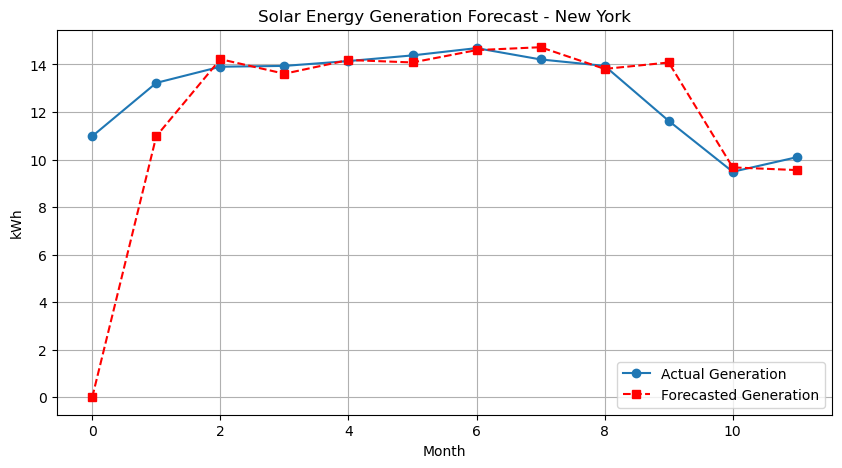

In [521]:
# Plot actual vs forecasted data
plt.figure(figsize=(10,5))
plt.plot(solar_df.index, solar_energy_output["Energy Generation"], marker="o", label="Actual Generation")
plt.plot(solar_df.index, solar_df["Forecasted Generation"], marker="s", linestyle="dashed", label="Forecasted Generation", color="red")
plt.title("Solar Energy Generation Forecast - New York")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend()
plt.grid()
plt.show()

## Fetch EIA data for electricity prices and consumption

In [575]:
# Define your EIA API key
# you need to use API v2 to make a request from EIA. The API v1 is not used anymore. You can check the documentation for API v2 at the EIA website
# You need to change your API Key

EIA_API_KEY = "O17KLa0vZQhAK2XbEPGvbpqti5cblmEDejVdTiSZ"  # Replace with your actual API key

# Base URL for API requests
BASE_URL = "https://api.eia.gov/v2/electricity"

# Define API endpoints
urls = {
    "electricity_prices": f"{BASE_URL}/retail-sales/data/?api_key={EIA_API_KEY}&"
                          "facets[stateid][]=NY&"
                          "facets[sectorid][]=RES&"  # pulling only residential data
                          #"facets[sectorid][]=COM&"
                          #"facets[sectorid][]=IND&"
                          "data[]=price&"
                          "frequency=monthly&"
                          "start=2019-01&end=2024-12",

    "electricity_consumption": f"{BASE_URL}/retail-sales/data/?api_key={EIA_API_KEY}&"
                               "facets[stateid][]=NY&" "facets[sectorid][]=RES&"
                               "data[]=sales&"
                               "frequency=monthly&"
                               "start=2019-01&end=2024-12",

}

# Function to fetch and process data
def fetch_eia_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if "response" in data and "data" in data["response"]:
            return pd.DataFrame(data["response"]["data"])
        else:
            print("Unexpected data format:", data)
            return None
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

# Fetch data
df_prices = fetch_eia_data(urls["electricity_prices"])
df_consumption = fetch_eia_data(urls["electricity_consumption"])


print("Data fetched and saved successfully!")

Data fetched and saved successfully!


,period,stateid,stateDescription,sectorid,sectorName,price,price-units
0,2023-12,NY,New York,RES,residential,22.42,cents per kilowatt-hour
1,2023-06,NY,New York,RES,residential,21.63,cents per kilowatt-hour
2,2024-05,NY,New York,RES,residential,23.6,cents per kilowatt-hour
3,2024-02,NY,New York,RES,residential,24.24,cents per kilowatt-hour
4,2023-09,NY,New York,RES,residential,23.24,cents per kilowatt-hour
...,...,...,...,...,...,...,...
67,2024-08,NY,New York,RES,residential,25.13,cents per kilowatt-hour
68,2024-07,NY,New York,RES,residential,25.02,cents per kilowatt-hour
69,2023-11,NY,New York,RES,residential,22.85,cents per kilowatt-hour
70,2024-11,NY,New York,RES,residential,24.7,cents per kilowatt-hour


,period,stateid,stateDescription,sectorid,sectorName,sales,sales-units
0,2023-12,NY,New York,RES,residential,4294.03398,million kilowatt hours
1,2023-06,NY,New York,RES,residential,3849.08287,million kilowatt hours
2,2024-05,NY,New York,RES,residential,3368.08758,million kilowatt hours
3,2024-02,NY,New York,RES,residential,4193.45946,million kilowatt hours
4,2023-09,NY,New York,RES,residential,4622.04973,million kilowatt hours
...,...,...,...,...,...,...,...
67,2024-08,NY,New York,RES,residential,5679.64323,million kilowatt hours
68,2024-07,NY,New York,RES,residential,6035.48959,million kilowatt hours
69,2023-11,NY,New York,RES,residential,3608.97419,million kilowatt hours
70,2024-11,NY,New York,RES,residential,3418.64729,million kilowatt hours


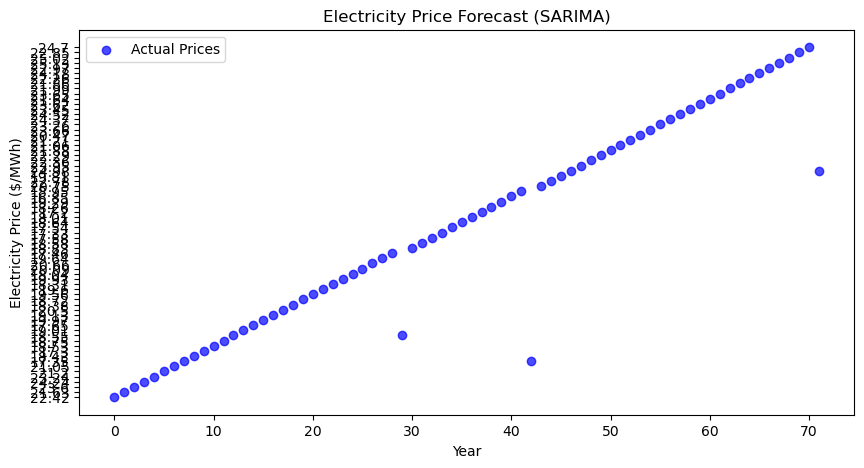

In [577]:
display(df_prices)
display(df_consumption)
plt.figure(figsize=(10, 5))
plt.scatter(df_prices.index, df_prices['price'], label='Actual Prices', color='blue', alpha=0.7)  
#plt.plot(forecast_df.index, forecast_df['Predicted_Price'], label='Forecasted Prices', linestyle='dashed', color='red')  
plt.xlabel('Year')
plt.ylabel('Electricity Price ($/MWh)')
plt.title('Electricity Price Forecast (SARIMA)')
plt.legend()
plt.show()

## Forecast electricity prices

C:\Users\cemgu\AppData\Local\Temp\ipykernel_7588\3299973192.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  price_data['price'].interpolate(inplace=True)  # Fill missing values
C:\Users\cemgu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\cemgu\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A

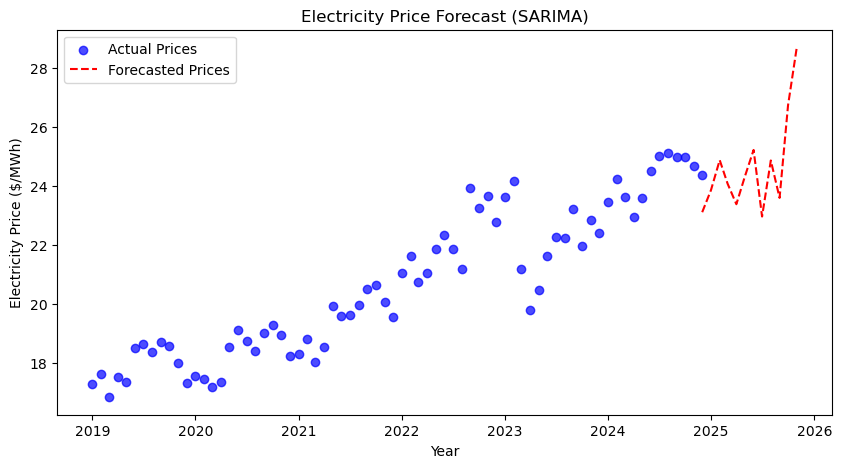

In [580]:
def forecast_electricity_prices_sarima(price_data: pd.DataFrame, forecast_months=12):
    """
    Forecast electricity prices using a SARIMA model.

    Parameters:
        price_data (pd.DataFrame): Time-series electricity price data with 'Date' and 'Price'.
        forecast_months (int): Number of months to forecast.

    Returns:
        pd.DataFrame: DataFrame with actual and predicted prices.
    """
    
    if 'period' in price_data.columns:
        price_data['period'] = pd.to_datetime(price_data['period'])
        price_data.set_index('period', inplace=True)
    
    # Convert Price to numeric (fix for ValueError)
    price_data['price'] = pd.to_numeric(price_data['price'], errors='coerce')
    price_data['price'].interpolate(inplace=True)  # Fill missing values
    
    # Handle missing values (if any)
    #price_data = price_data.asfreq('ME').interpolate()

    # Split data into training and testing sets (80% train, 20% test)
    train_size = int(len(price_data) * 0.8)
    train_data, test_data = price_data[:train_size], price_data[train_size:]

    # Fit SARIMA model (optimized parameters: (p,d,q)(P,D,Q,s))
    model = sm.tsa.SARIMAX(train_data['price'], 
                           order=(2, 1, 2),   # ARIMA components (p,d,q)
                           seasonal_order=(1, 1, 1, 12),  # Seasonal (P,D,Q,s) with s=12 months
                           enforce_stationarity=False, 
                           enforce_invertibility=False)

    model_fit = model.fit()

    # Forecasting
    forecast_index = pd.date_range(start=price_data.index[-1], periods=forecast_months+1, freq='ME')[1:]
    forecast_values = model_fit.forecast(steps=forecast_months)

    # Create a DataFrame for the forecast
    forecast_df = pd.DataFrame({'period': forecast_index, 'Predicted_Price': forecast_values})

    if 'period' in forecast_df.columns:
        forecast_df['period'] = pd.to_datetime(forecast_df['period'])
        forecast_df.set_index('period', inplace=True)

    
    # Plot results
    plt.figure(figsize=(10, 5))
    plt.scatter(df_prices.index, df_prices['price'], label='Actual Prices', color='blue', alpha=0.7)  
    plt.plot(forecast_df.index, forecast_df['Predicted_Price'], label='Forecasted Prices', linestyle='dashed', color='red')  
    plt.xlabel('Year')
    plt.ylabel('Electricity Price ($/MWh)')
    plt.title('Electricity Price Forecast (SARIMA)')
    plt.legend()
    plt.show()


    return forecast_df

# Assume we have a dataset with columns: 'Date' and 'Price'


# Forecast the next 12 months
forecasted_prices_sarima = forecast_electricity_prices_sarima(df_prices, forecast_months=12)


### Please note that SARIMA, due to being moving average function, gives a compressed prices. In other words, the real prices and are more scattered than the forecasted prices. This is to be expected because because ARIMA and SARIMA uses average to forecast. However, this would be a huge assumption to expect the prices to be in that range. So, Let's use XGBoost which is better for non-linear forecasting. 

## XGboost alternative for forecasting prices:

C:\Users\cemgu\AppData\Local\Temp\ipykernel_7588\59046821.py:83: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Date': pd.date_range(start='2019-01-01', periods=60, freq='M'),
C:\Users\cemgu\AppData\Local\Temp\ipykernel_7588\59046821.py:65: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=price_data.index[-1], periods=forecast_months+1, freq='M')[1:]


Mean Absolute Error: 0.21


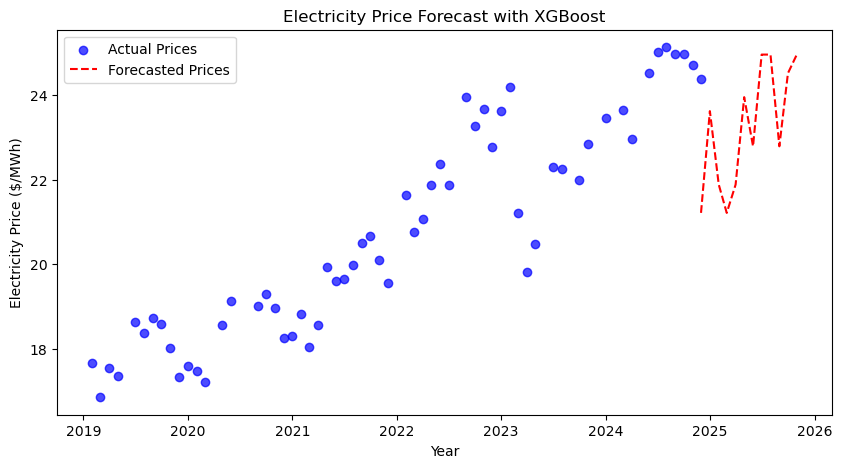

            Predicted_Price
period                     
2024-11-30        21.211620
2024-12-31        23.617947
2025-01-31        21.881771
2025-02-28        21.210205
2025-03-31        21.880356
2025-04-30        23.948774
2025-05-31        22.786015
2025-06-30        24.955956
2025-07-31        24.955956
2025-08-31        22.786015
2025-09-30        24.514198
2025-10-31        24.955956


In [582]:
def prepare_features(price_data, lag=12):
    """
    Prepare features for XGBoost by adding lagged price values and time-based features.

    Parameters:
        price_data (pd.DataFrame): Time-series electricity price data with 'Date' and 'Price'.
        lag (int): Number of lag months to include as features.

    Returns:
        pd.DataFrame: DataFrame with added features.
    """
    if 'period' in price_data.columns:
        price_data['period'] = pd.to_datetime(price_data['period'])
        price_data.set_index('period', inplace=True)

    # Create time-based features
    price_data['Year'] = price_data.index.year
    price_data['Month'] = price_data.index.month

    # Add lagged price values as features
    for i in range(1, lag + 1):
        price_data[f'Lag_{i}'] = price_data['price'].shift(i)

    # Drop rows with NaN values from shifting
    price_data.dropna(inplace=True)

    return price_data

def forecast_electricity_prices_xgb(price_data, forecast_months=12):
    """
    Forecast electricity prices using XGBoost.

    Parameters:
        price_data (pd.DataFrame): Time-series electricity price data with 'Date' and 'Price'.
        forecast_months (int): Number of months to forecast.

    Returns:
        pd.DataFrame: DataFrame with actual and predicted prices.
    """
    # Prepare data with lagged features
    data = prepare_features(price_data)

    # Split into training and testing sets
    X = data.drop(columns=['price'])
    X = data.select_dtypes(include=[np.number])  # Keeps only numeric columns
    y = data['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train XGBoost model
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate error
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae:.2f}')

    # Forecast future months
    forecast_data = X.iloc[-forecast_months:].copy()
    future_predictions = model.predict(forecast_data)

    # Create forecast DataFrame
    forecast_index = pd.date_range(start=price_data.index[-1], periods=forecast_months+1, freq='M')[1:]
    forecast_df = pd.DataFrame({'period': forecast_index, 'Predicted_Price': future_predictions})
    forecast_df.set_index('period', inplace=True)

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 5))
    plt.scatter(price_data.index, price_data['price'], label='Actual Prices', color='blue', alpha=0.7)
    plt.plot(forecast_df, label='Forecasted Prices', linestyle='dashed', color='red')
    plt.xlabel('Year')
    plt.ylabel('Electricity Price ($/MWh)')
    plt.title('Electricity Price Forecast with XGBoost')
    plt.legend()
    plt.show()

    return forecast_df

# Example Usage:
example_data = pd.DataFrame({
    'Date': pd.date_range(start='2019-01-01', periods=60, freq='M'),
    'Price': np.random.uniform(50, 100, 60)  # Simulated electricity prices
})

# Forecast the next 12 months
forecasted_prices_xgb = forecast_electricity_prices_xgb(df_prices, forecast_months=12)
print(forecasted_prices_xgb)

### As you can see above, XGBoost creates a smoother more fitting outcome than SARIMA (Seasonal AutoRegressive Moving Average). This is because XGboost handles non-linearity better than ARIMA or SARIMA. This is especially true in this case because of the scattered data in energy prices. 